<a href="https://colab.research.google.com/github/Tony5t4rk/ML-2021-Spring/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2-1 Phoneme Classification**

Author: Yang Liu

Study notes：[機器學習2021 学习笔记-Deep Learning](https://www.wolai.com/tony5t4rk/fPrLCZXbVHWg5zxj5kDicY)

This program is modified based on [Sample Code](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW02/HW02-1.ipynb#scrollTo=emUd7uS7crTz)。

# Mount into Google Drive & Show GPU

In [199]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab/ML 2021 Spring/HW02'
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab/ML 2021 Spring/HW02
Thu May 13 10:59:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    36W / 250W |   3263MiB / 16280MiB |      0%      Default |
|                               |                      |              

# Download Data from Google Drive

In [200]:
# !gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
# !unzip data.zip
!apt-get -qq install -y tree
!tree -L 2

train_file = 'timit_11/train_11.npy'
train_label_file = 'timit_11/train_label_11.npy'
test_file = 'timit_11/test_11.npy'

.
├── Classification.ipynb
├── data.zip
├── Learning curve of DNN Model.svg
├── models
│   └── model.pth
├── timit_11
│   ├── test_11.npy
│   ├── train_11.npy
│   └── train_label_11.npy
└── timit-11.pred.csv

2 directories, 8 files


# Import Package

In [201]:
import numpy as np
import os
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set a random seed for reproducibility
my_seed = 42096
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# Plot Utility

In [202]:
def plot_learning_curve(loss_record, title=''):
    n_epochs = len(loss_record['train'])
    x_1 = range(n_epochs)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_1, loss_record['val'], c='tab:cyan', label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig('Learning curve of {}.svg'.format(title))
    plt.show()

# Hyper-Parameters

In [203]:
os.makedirs('models', exist_ok=True)

config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'val_ratio': 0.01,
    'n_epochs': 150,
    'batch_size': 2048,
    'optim_hparams': {
        'lr': 0.001
    },
    'scheduler': {
        'mode': 'max',
        'factor': 0.5,
        'patience': 8,
        'threshold_mode': 'abs',
        'cooldown': 3,
        'min_lr': 0.000005,
        'verbose': True
    },
    'early_stop': True,
    'early_stop_epochs': 15,
    'model_path': 'models/model.pth',
    'pred_file': 'timit-11.pred.csv'
}

print(f'device: {config["device"]}')

device: cuda


# Data Process

## Pre-Process

In [204]:
train_x, train_y = np.load(train_file), np.load(train_label_file)
test_x = np.load(test_file)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=config['val_ratio'], random_state=my_seed, stratify=train_y)

## Dataset

In [205]:
class TIMIT11_Dataset(Dataset):
    def __init__(self, x, y=None, mean=None, std=None):
        self.data = torch.from_numpy(x).float().reshape(-1, 1, 11, 39)
        if y is not None:
            self.label = torch.LongTensor(y.astype(np.int))
        else:
            self.label = None
    
    def __getitem__(self, index):
        if self.label is not None:
            return self.data[index], self.label[index]
        else:
            return self.data[index]
    
    def __len__(self):
        return len(self.data)

train_dataset = TIMIT11_Dataset(train_x, train_y)
val_dataset = TIMIT11_Dataset(val_x, val_y)
test_dataset = TIMIT11_Dataset(test_x)

print(f'Train Dataset: {len(train_dataset)} samples')
print(f'Valid Dataset: {len(val_dataset)} samples')
print(f'Test Dataset: {len(test_dataset)} samples')

del train_x, train_y, val_x, val_y, test_x
gc.collect()

Train Dataset: 1217632 samples
Valid Dataset: 12300 samples
Test Dataset: 451552 samples


3535

## DataLoader

In [206]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# Model

In [207]:
class Net(nn.Module):
    def __init__(self, p=0.3):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 256, (3, 39)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(p=p),

            nn.Conv2d(256, 512, (3, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(p=p),

            nn.Conv2d(512, 1024, (3, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Dropout2d(p=p),

            nn.Flatten(),

            # 11 * 39 -> 9 * 1 -> 7 * 1 -> 5 * 1
            nn.Linear(1024 * 5, 1560),
            nn.BatchNorm1d(1560),
            nn.PReLU(),
            nn.Dropout(p=p),
            
            nn.Linear(1560, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(p=p),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(p=p),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.PReLU(),
            nn.Dropout(p=p),

            nn.Linear(64, 39),
            nn.BatchNorm1d(39)
        )
    
    def forward(self, x):
        return self.net(x)

model = Net().to(config['device'])

# Training

In [208]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **config['optim_hparams'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **config['scheduler'])

In [209]:
loss_record = {'train': [], 'val': []}

if config['early_stop']:
    min_val_loss = float('inf')
    early_stop_cnt = 0

epoch = 0
while epoch < config['n_epochs']:
    model.train()
    train_loss = []
    for x, y in train_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = sum(train_loss) / len(train_loss)
    loss_record['train'].append(train_loss)

    model.eval()
    val_loss = []
    for x, y in val_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        with torch.no_grad():
            pred = model(x)
        loss = criterion(pred, y)
        val_loss.append(loss.item())
    val_loss = sum(val_loss) / len(val_loss)
    scheduler.step(val_loss)
    loss_record['val'].append(val_loss)

    if config['early_stop']:
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model, config['model_path'])
            print(f'Early Stop Saving Model on [ Epoch {epoch + 1:03d}/{config["n_epochs"]:03d} ] Train Loss: {train_loss:.5f} Valid Loss: {val_loss:.5f}')
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
    else:
        torch.save(model, config['model_path'])
        print(f'[ Epoch {epoch + 1:03d}/{config["n_epochs"]:03d} ] Train Loss: {train_loss:.5f} Valid Loss: {val_loss:.5f}')
    
    epoch += 1

    if config['early_stop'] and early_stop_cnt > config['early_stop_epochs']:
        break

print(f'Finish Train After {epoch} Epochs')

Early Stop Saving Model on [ Epoch 001/150 ] Train Loss: 1.71827 Valid Loss: 1.15779
Early Stop Saving Model on [ Epoch 002/150 ] Train Loss: 1.22644 Valid Loss: 0.97803
Early Stop Saving Model on [ Epoch 003/150 ] Train Loss: 1.08845 Valid Loss: 0.92098
Early Stop Saving Model on [ Epoch 004/150 ] Train Loss: 1.01452 Valid Loss: 0.89259
Early Stop Saving Model on [ Epoch 005/150 ] Train Loss: 0.96465 Valid Loss: 0.68652
Early Stop Saving Model on [ Epoch 007/150 ] Train Loss: 0.90079 Valid Loss: 0.66460
Early Stop Saving Model on [ Epoch 008/150 ] Train Loss: 0.87803 Valid Loss: 0.63605
Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
Early Stop Saving Model on [ Epoch 010/150 ] Train Loss: 0.84127 Valid Loss: 0.63350
Early Stop Saving Model on [ Epoch 011/150 ] Train Loss: 0.80276 Valid Loss: 0.58296
Early Stop Saving Model on [ Epoch 018/150 ] Train Loss: 0.73492 Valid Loss: 0.56523
Early Stop Saving Model on [ Epoch 019/150 ] Train Loss: 0.72987 Valid Loss: 0.52843
Epo

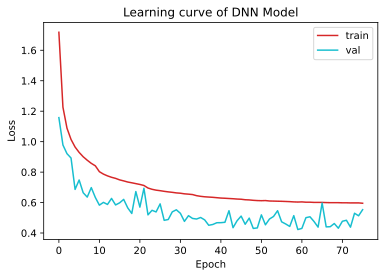

In [210]:
plot_learning_curve(loss_record, title='DNN Model')

# Testing

In [211]:
del model
model = torch.load(config['model_path']).to(config['device'])

In [212]:
model.eval()
preds = []
for x in test_dataloader:
    x = x.to(config['device'])
    with torch.no_grad():
        pred = model(x)
        _, pred = torch.max(pred, dim=1)
    preds.append(pred.detach().cpu())
preds = torch.cat(preds, dim=0).numpy()

In [213]:
print(f'Saving Result to {config["pred_file"]}')

with open(config['pred_file'], 'w') as fp:
    fp.write('Id,Class\n')
    for id, pred in enumerate(preds):
        fp.write(f'{id},{pred}\n')

Saving Result to timit-11.pred.csv


# Result